# Domain Uncertainty

## In Domain Uncertainty
In-domain uncertainty represents the uncertainty related to inputs drawn from a distribution believed to be equal to the training data distribution. Thus, any uncertainty from in-domain inputs result from our model's inability to properly understand an in-domain sample, indicating a design error in our model choice (model uncertainty), or the complexity of the problem (data uncertainty). In this tutorial we train on all the numbers, establishing numbers 0-9 as "in domain", and test on those same numbers to show in domain uncertainty.

[1]

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Define numbers in domain
in_domain = [0,1,2,3,4,5,6,7,8,9]

# Load the MNIST training dataset
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = in_domain, num_entries_per_digit=1000, transform=transform)

In [2]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
import push.bayes.swag
import push.bayes.stein_vgd
from experiments.nns.lenet.lenet import LeNet

# Create data loaders
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50
lr = 0.01
n = 25

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=n,
        lr = lr
    )

100%|██████████| 50/50 [09:05<00:00, 10.91s/it, loss=tensor(0.0441)]


In [3]:
pretrain_epochs = 25
swag_epochs = 25
swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.CrossEntropyLoss(),
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices = 2,
    num_models = n,
    lr = lr
)

  0%|          | 0/25 [00:00<?, ?it/s]Exception in thread Thread-13718 (worker):
Traceback (most recent call last):
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jtsegaye/push/push/lib/node_event_loop.py", line 665, in worker
    raise e
  File "/home/jtsegaye/push/push/lib/node_event_loop.py", line 651, in worker
    loss.backward()
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/torch/_tensor.py", line 522, in backward
    torch.autograd.backward(
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/torch/autograd/__init__.py", line 266, in backward
   

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 1 has a total capacity of 23.69 GiB of which 8.06 MiB is free. Process 3354996 has 20.31 GiB memory in use. Including non-PyTorch memory, this process has 3.36 GiB memory in use. Of the allocated memory 2.94 GiB is allocated by PyTorch, and 94.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [ ]:

svgd = push.bayes.stein_vgd.train_svgd(
    train_loader,                       # Dataloader
    torch.nn.CrossEntropyLoss(),        # Loss Fn
    epochs,                             # Epochs
    10,                                  # Number of particles
    LeNet,                              # NN
    lengthscale = 0.25,                  # Lengthscale
    lr = 3e-1,                          # Learning Rate
    num_devices = 2,                    # Number of devices
)

100%|██████████| 50/50 [20:10<00:00, 24.21s/it, loss=tensor(1.7685)]


In [ ]:
test_dataset = SelectMNISTDataset(root=mnist_directory, train=False, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=100, transform=transform)
test_batch_size=100
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
ensemble_outputs = ensemble.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])
swag_outputs = swag.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])
svgd_outputs = svgd.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])

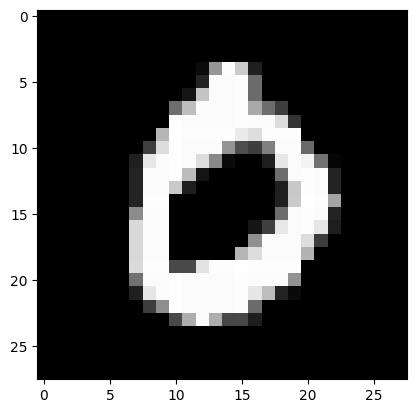

In [ ]:
# Display rotated images
# num_images_to_display = 
import matplotlib.pyplot as plt

def get_image(number_to_display, dataloader, batch_size):
    number_to_display = number_to_display
    cur_batch = 0
    idx = 0
    for images, labels in test_loader:
        img = images[idx]
        lbl = labels[idx]
        if cur_batch == number_to_display:
            return img
        cur_batch += 1

number_to_display = 0
img = get_image(number_to_display, test_loader, test_batch_size)
idx_image = test_batch_size * number_to_display
plt.imshow(img.squeeze(), cmap='gray')

Trained on all numbers, testing on 9

In [ ]:
import numpy as np
def plot_probabilities(outputs, title):
    # Sample average prediction probabilities and standard deviations
    digits = np.arange(10)  # Digits 0-9
    # avg_probs = np.array([0.92, 0.91, 0.93, 0.94, 0.92, 0.95, 0.94, 0.92, 0.93, 0.6])  # Sample average probs
    # std_devs = np.array([0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.03, 0.1])  # Sample std devs
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    # Plotting
    plt.errorbar(digits, torch.mean(outputs["prob"], dim=1).squeeze()[idx_image], yerr=outputs["std"][idx_image], fmt='o', capsize=5, label='In-Domain (0-9)')
    # plt.scatter(9, 0.6, color='red', label='Out-of-Domain (9)')

    plt.xticks(digits)
    plt.xlabel('Digits')
    plt.ylabel('Average Prediction Probability')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Second subplot for the MNIST image
    plt.subplot(2, 1, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')  # Remove axis
    plt.title('MNIST Image')

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()

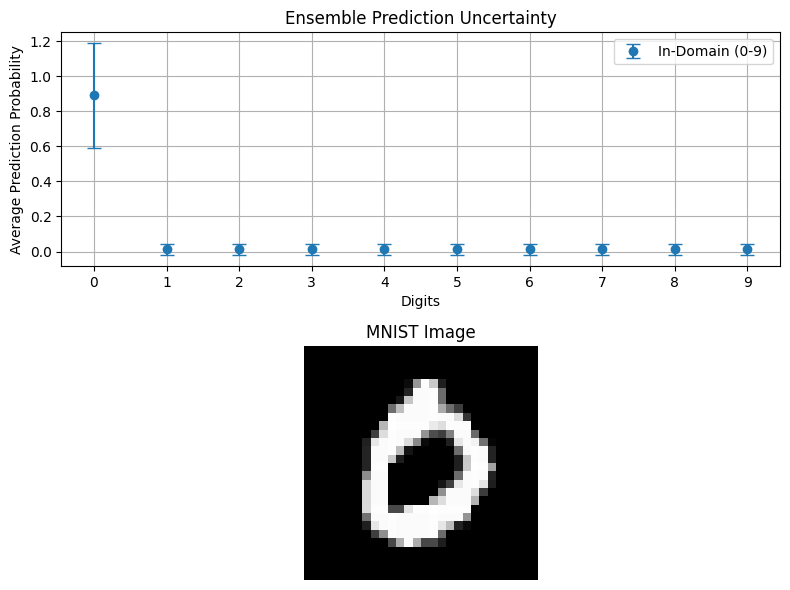

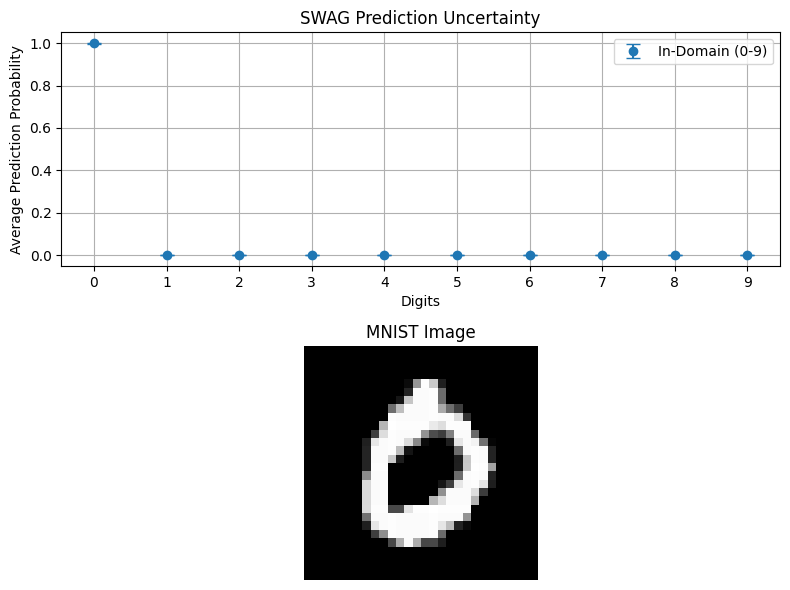

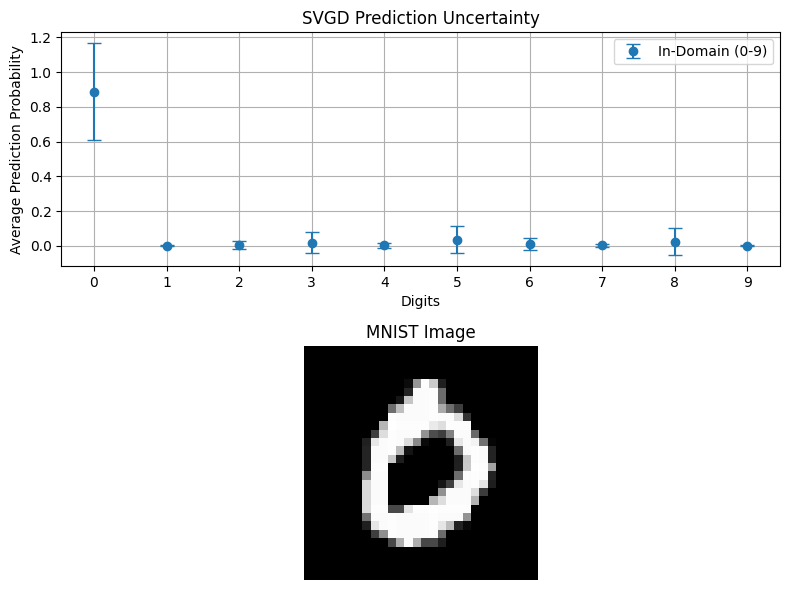

In [ ]:
plot_probabilities(ensemble_outputs, "Ensemble Prediction Uncertainty")
plot_probabilities(swag_outputs, "SWAG Prediction Uncertainty")
plot_probabilities(svgd_outputs, "SVGD Prediction Uncertainty")

## Out of Domain Uncertainty
Out of domain uncertainty represents the uncertainty related to inputs drawn from the subspace of unknown data. In this tutorial we examine the MNIST dataset, and train on set of numbers 1-8, establishing our "in-domain" as the numbers 1-8. By testing on the number 9, an out of domain input, we can determine how uncertain our model is when encountering data it is not equipped to handle.

[1]

### Dataset

In [ ]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset

# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Define in and out domain numbers
in_domain = [0,2,4,6,8]
out_domain = [1,3,5,7,9]

# Load the MNIST training dataset
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = in_domain, num_entries_per_digit=1000, transform=transform)

In [ ]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=n,
        cache_size=25
    )


100%|██████████| 50/50 [02:59<00:00,  3.59s/it, loss=tensor(0.0123)]


In [ ]:
pretrain_epochs = 25
swag_epochs = 25
swag = push.bayes.swag.train_mswag(
    train_loader,
    torch.nn.CrossEntropyLoss(),
    pretrain_epochs,
    swag_epochs,
    LeNet,
    num_devices = 2,
    num_models = n,
    lr = lr,
    mswag_state={},
)

100%|██████████| 25/25 [02:32<00:00,  6.09s/it, loss=tensor(0.0345)]


In [ ]:
svgd = push.bayes.stein_vgd.train_svgd(
    train_loader,                       # Dataloader
    torch.nn.CrossEntropyLoss(),        # Loss Fn
    epochs,                             # Epochs
    10,                                  # Number of particles
    LeNet,                              # NN
    lengthscale = 0.25,                  # Lengthscale
    lr = 3e-1,                          # Learning Rate
    num_devices = 2,                    # Number of devices
)

  0%|          | 0/50 [00:00<?, ?it/s]Exception in thread Thread-50777 (worker):
Traceback (most recent call last):
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jtsegaye/push/push/lib/node_event_loop.py", line 665, in worker
    raise e
  File "/home/jtsegaye/push/push/lib/node_event_loop.py", line 651, in worker
    loss.backward()
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/torch/_tensor.py", line 522, in backward
    torch.autograd.backward(
  File "/home/jtsegaye/anaconda3/envs/push_env/lib/python3.10/site-packages/torch/autograd/__init__.py", line 266, in backward
   

IndexError: pop from empty list

In [ ]:
test_dataset = SelectMNISTDataset(root=mnist_directory, train=False, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=100, transform=transform)
test_batch_size = 100
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
ensemble_outputs = ensemble.posterior_pred(test_loader, f_reg=False, mode=["mode","logits","prob", "std"])
swag_outputs = swag.posterior_pred(test_loader, f_reg=False, mode=["mode","logits","prob", "std"])
svgd_outputs = svgd.posterior_pred(test_loader, f_reg=False, mode=["mode","logits", "prob", "std"])

Trained on numbers 0-8, testing on number 9 image

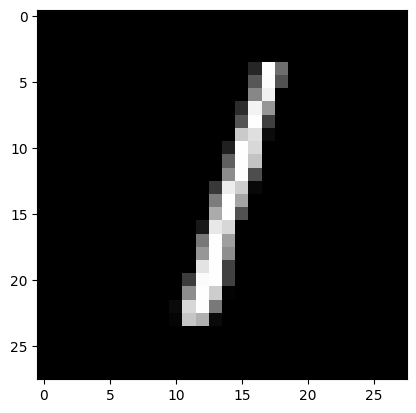

In [ ]:
# Display rotated images
# num_images_to_display = 
import matplotlib.pyplot as plt

def get_image(number_to_display, dataloader, batch_size):
    number_to_display = number_to_display
    cur_batch = 0
    idx = 0
    for images, labels in test_loader:
        img = images[idx]
        lbl = labels[idx]
        if cur_batch == number_to_display:
            return img
        cur_batch += 1

number_to_display = 1
img = get_image(number_to_display, test_loader, test_batch_size)
idx_image = test_batch_size * number_to_display
plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_probabilities_oos(outputs, title, number):
    number_to_display = number
    img = get_image(number_to_display, test_loader, test_batch_size)
    idx_image = test_batch_size * number_to_display
    plt.figure(figsize=(8, 6))
    digits = np.arange(10)
    plt.subplot(2, 1, 1)
    # Plotting
    plt.errorbar(in_domain, torch.mean(outputs["prob"], dim=1).squeeze()[idx_image][in_domain], yerr=outputs["std"][idx_image][in_domain], fmt='o', capsize=5, label="In-Domain")
    plt.errorbar(out_domain, torch.mean(outputs["prob"], dim=1).squeeze()[idx_image][out_domain], yerr=outputs["std"][idx_image][out_domain], fmt='o', capsize=5, label ="Out-Domain")

    plt.xticks(digits)
    plt.xlabel('Digits')
    plt.ylabel('Average Prediction Probability')
    plt.title(title)
    plt.legend()
    plt.grid(True)


    # Second subplot for the MNIST image
    plt.subplot(2, 1, 2)
    img = get_image(number_to_display, test_loader, test_batch_size)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')  # Remove axis
    plt.title('MNIST Image')

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()

    plt.show()

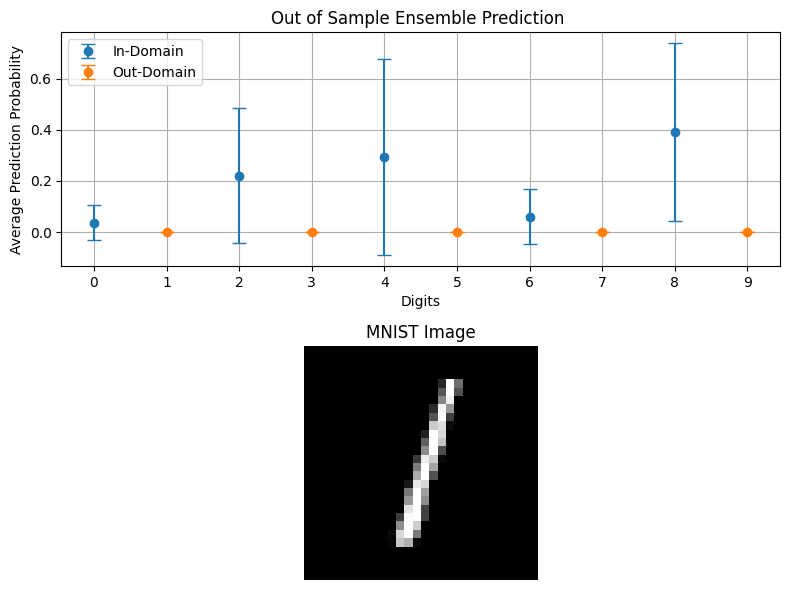

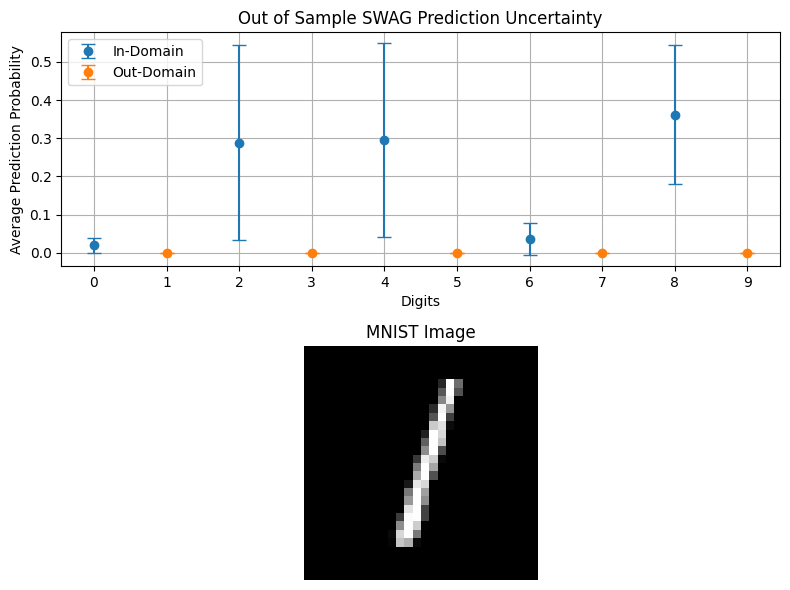

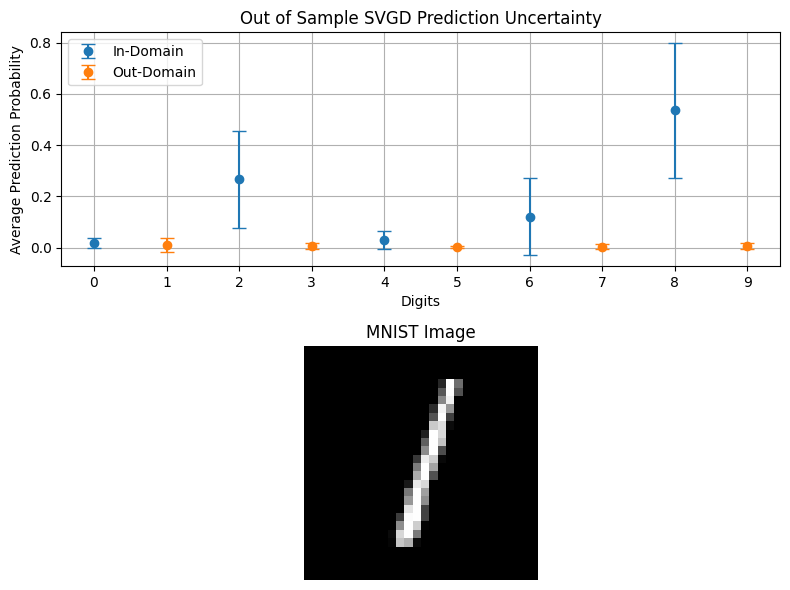

In [ ]:
plot_probabilities_oos(ensemble_outputs, "Out of Sample Ensemble Prediction ", out_domain[0])
plot_probabilities_oos(swag_outputs, "Out of Sample SWAG Prediction Uncertainty", out_domain[0])
plot_probabilities_oos(svgd_outputs, "Out of Sample SVGD Prediction Uncertainty", out_domain[0])

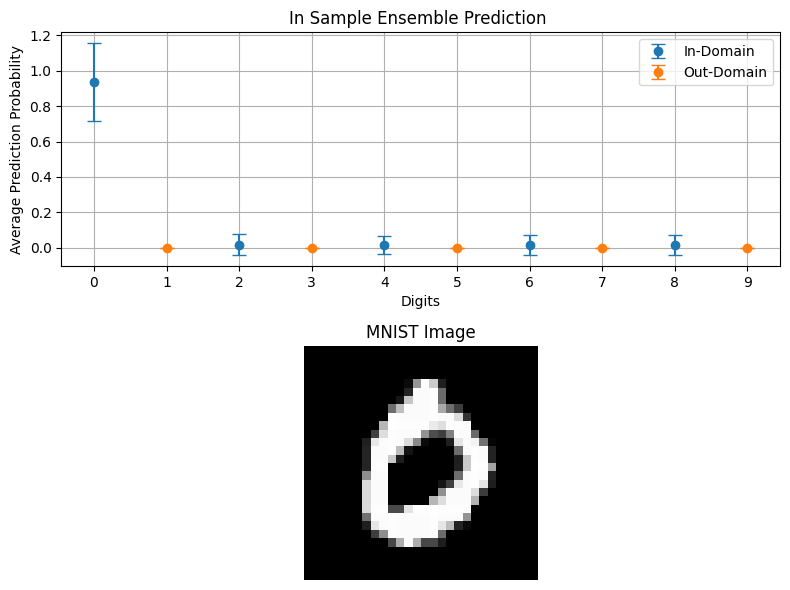

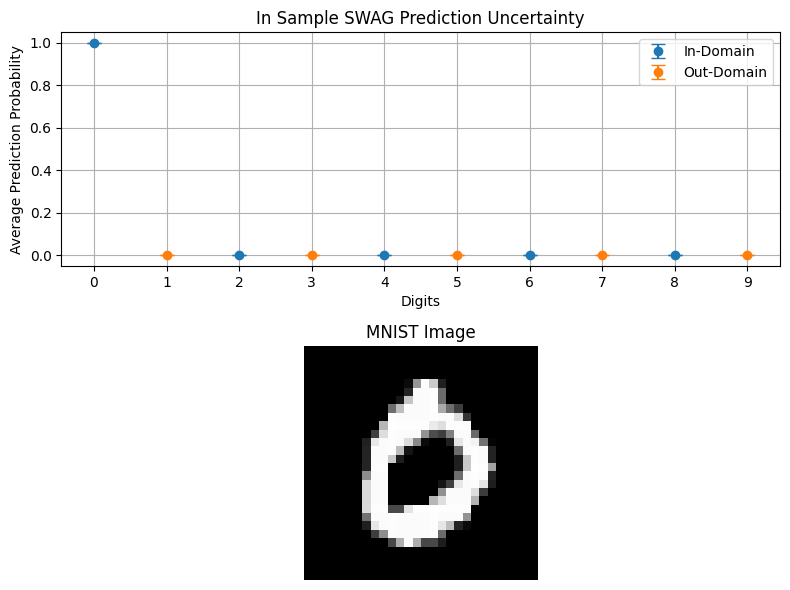

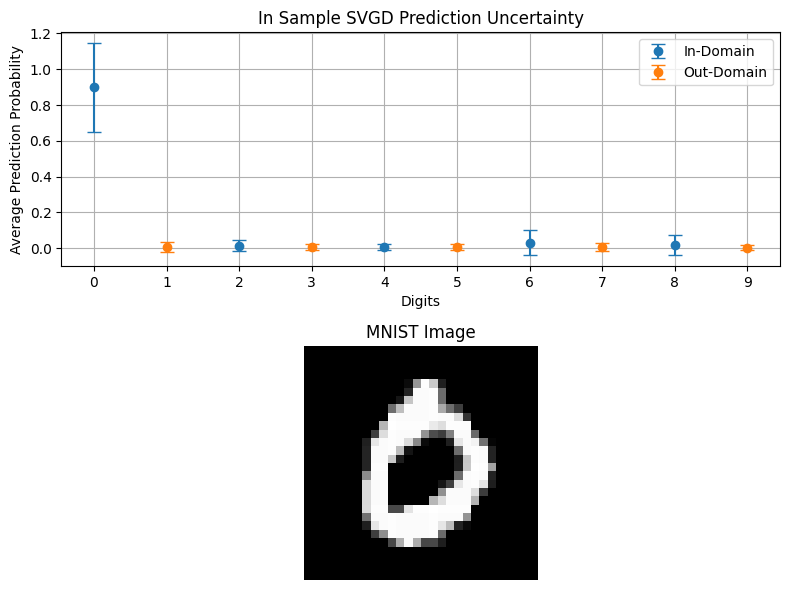

In [ ]:
plot_probabilities_oos(ensemble_outputs, "In Sample Ensemble Prediction ", in_domain[0])
plot_probabilities_oos(swag_outputs, "In Sample SWAG Prediction Uncertainty", in_domain[0])
plot_probabilities_oos(svgd_outputs, "In Sample SVGD Prediction Uncertainty", in_domain[0])

We can see that the model's most probable prediction (4) has a very high degree of uncertainty, demonstrated by its very large standard deviation.

Furthermore, we can visualize the entropy of our predictions for out of domain and in domain samples. 

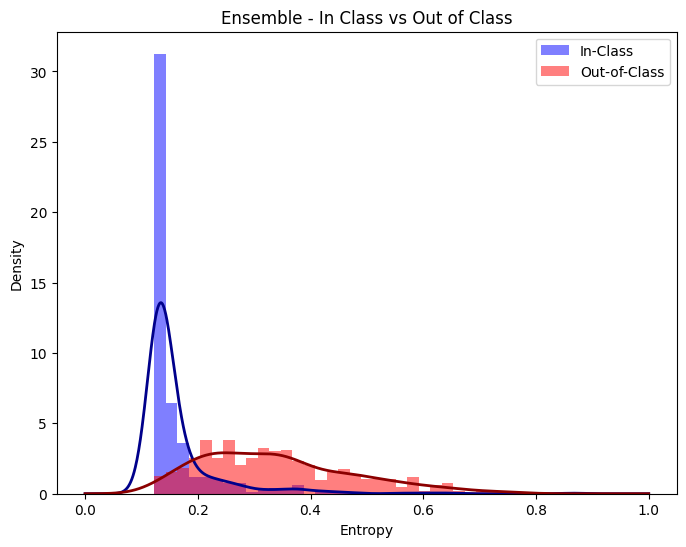

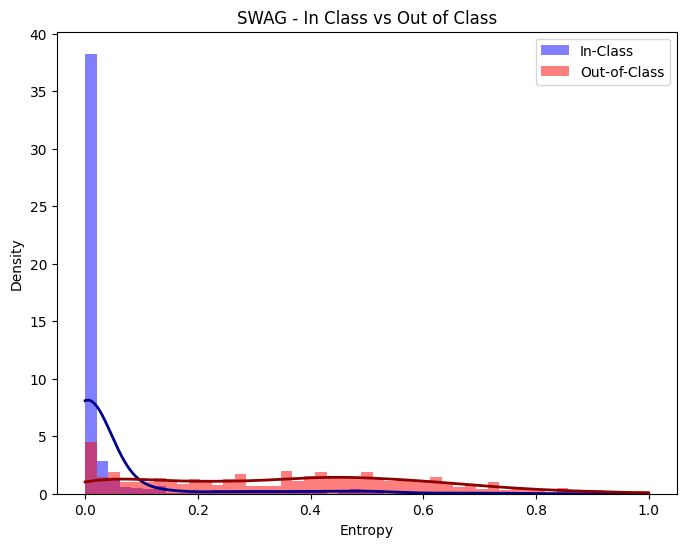

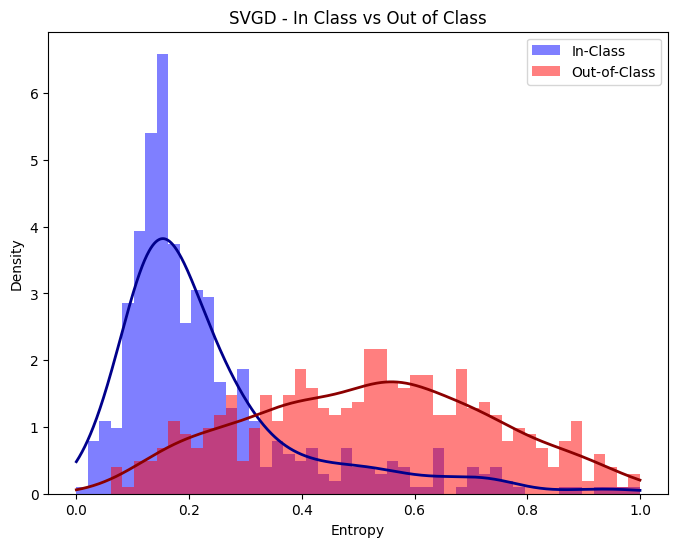

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_entropy(outputs, title, bins):
    # Define which labels are considered in-class
    in_class_labels = torch.tensor(in_domain)  # Update this list as needed
    # Extract probabilities and predicted classes
    probabilities = outputs['prob']
    filtered_probabilities = probabilities[:, :, in_domain]
    # Calculate predictive entropy for the filtered in-domain probabilities
    # Adjust the calculation to work with the multi-model setup
    entropies = -(filtered_probabilities * torch.log(filtered_probabilities + 1e-10)).sum(dim=2)
    # Average entropy across all models for each sample
    average_entropy = entropies.mean(dim=1)
    # Get true labels (assuming the test_loader has dataset with true labels as the second element)
    true_labels = torch.tensor([label for _, label in test_dataset])
    # # Classify predictions as in-class or out-of-class based on specified labels
    in_class = torch.isin(true_labels, in_class_labels)
    out_of_class = ~in_class
    # # Convert entropy to NumPy for plotting
    entropy_np = average_entropy.numpy()
    entropy_in_class_np = entropy_np[in_class.numpy()]
    entropy_out_of_class_np = entropy_np[out_of_class.numpy()]
    plt.figure(figsize=(8, 6))
    # Adjust your histogram plotting to use the provided bins
    if entropy_in_class_np.size > 0:
        hist_in_class = plt.hist(entropy_in_class_np, bins=bins, density=True, alpha=0.5, color='blue', label='In-Class')
        density_in_class = gaussian_kde(entropy_in_class_np)
        entropy_values_in_class = np.linspace(bins.min(), bins.max(), 1000)
        plt.plot(entropy_values_in_class, density_in_class(entropy_values_in_class), color='darkblue', linewidth=2)

    if entropy_out_of_class_np.size > 0:
        hist_out_of_class = plt.hist(entropy_out_of_class_np, bins=bins, density=True, alpha=0.5, color='red', label='Out-of-Class')
        density_out_of_class = gaussian_kde(entropy_out_of_class_np)
        entropy_values_out_of_class = np.linspace(bins.min(), bins.max(), 1000)
        plt.plot(entropy_values_out_of_class, density_out_of_class(entropy_values_out_of_class), color='darkred', linewidth=2)

    # The rest of your plotting code here
    plt.xlabel('Entropy')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()
# Define bins based on the range of entropies you expect across all models
# For example, if you expect entropies to be within 0 and 5, you can define:
bins = np.linspace(0, 1, 50)  # Adjust the range and number of bins as needed
# Call the function with the defined bins for each set of outputs
plot_entropy(ensemble_outputs, 'Ensemble - In Class vs Out of Class', bins)
plot_entropy(swag_outputs, 'SWAG - In Class vs Out of Class', bins) 
plot_entropy(svgd_outputs, 'SVGD - In Class vs Out of Class', bins)


NameError: name 'ensemble_outputs' is not defined

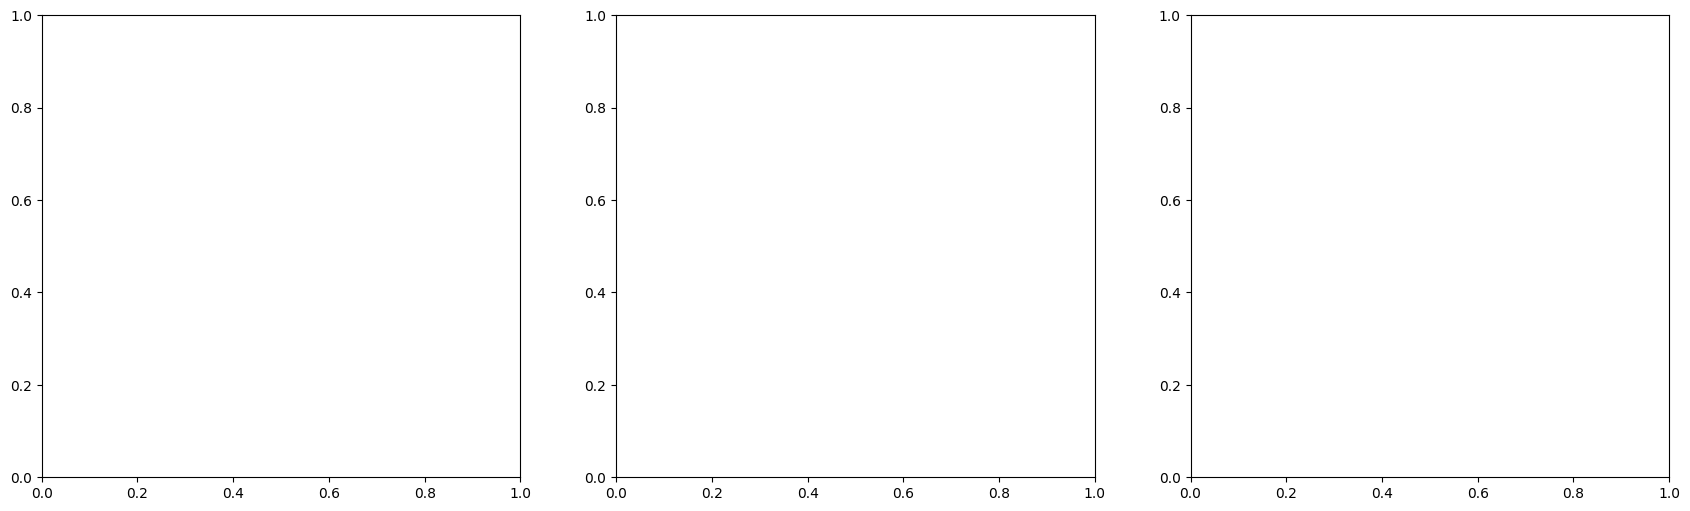

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_entropy(outputs, ax, title, bins):
    # Define which labels are considered in-class
    in_class_labels = torch.tensor(in_domain)  # Update this list as needed
    # Extract probabilities and predicted classes
    probabilities = outputs['prob']
    filtered_probabilities = probabilities[:, :, in_domain]
    # Calculate predictive entropy for the filtered in-domain probabilities
    entropies = -(filtered_probabilities * torch.log(filtered_probabilities + 1e-10)).sum(dim=2)
    # Average entropy across all models for each sample
    average_entropy = entropies.mean(dim=1)
    # Get true labels (assuming the test_loader has dataset with true labels as the second element)
    true_labels = torch.tensor([label for _, label in test_dataset])
    # Classify predictions as in-class or out-of-class based on specified labels
    in_class = torch.isin(true_labels, in_class_labels)
    out_of_class = ~in_class
    # Convert entropy to NumPy for plotting
    entropy_np = average_entropy.numpy()
    entropy_in_class_np = entropy_np[in_class.numpy()]
    entropy_out_of_class_np = entropy_np[out_of_class.numpy()]
    # Adjust your histogram plotting to use the provided bins
    if entropy_in_class_np.size > 0:
        ax.hist(entropy_in_class_np, bins=bins, density=True, alpha=0.5, color='blue', label='In-Class')
        density_in_class = gaussian_kde(entropy_in_class_np)
        entropy_values_in_class = np.linspace(bins.min(), bins.max(), 1000)
        ax.plot(entropy_values_in_class, density_in_class(entropy_values_in_class), color='darkblue', linewidth=2)

    if entropy_out_of_class_np.size > 0:
        ax.hist(entropy_out_of_class_np, bins=bins, density=True, alpha=0.5, color='red', label='Out-of-Class')
        density_out_of_class = gaussian_kde(entropy_out_of_class_np)
        entropy_values_out_of_class = np.linspace(bins.min(), bins.max(), 1000)
        ax.plot(entropy_values_out_of_class, density_out_of_class(entropy_values_out_of_class), color='darkred', linewidth=2)

    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend()

# Define bins based on the range of entropies you expect across all models
bins = np.linspace(0, 1, 50)  # Adjust the range and number of bins as needed

# Set up a single figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 6))  # You can adjust the figsize as needed
plot_entropy(ensemble_outputs, axs[0], 'Ensemble - In Class vs Out of Class', bins)
plot_entropy(swag_outputs, axs[1], 'SWAG - In Class vs Out of Class', bins)
plot_entropy(svgd_outputs, axs[2], 'SVGD - In Class vs Out of Class', bins)
plt.show()

References 

[1] Gawlikowski, J., Njieutcheu Tassi, C. R., Ali, M., Lee, J., Humt, M., Feng, J., Kruspe, A., Triebel, R., Jung, P., Roscher, R., Shahzad, M., Yang, W., Bamler, R., & Zhu, X. X. (2022). A Survey of Uncertainty in Deep Neural Networks. arXiv preprint arXiv:2107.03342.

[2] Maddox, W. J., Garipov, T., Izmailov, P., Vetrov, D., & Wilson, A. G. (2019). A simple baseline for Bayesian uncertainty in deep learning. In Proceedings of the 33rd Conference on Neural Information Processing Systems (NeurIPS 2019) (pp. [20]). Vancouver, Canada: New York University; Samsung AI Center Moscow; Samsung-HSE Laboratory, National Research University Higher School of Economics.